# Mask Use Detection - Edge Cases

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread, imshow

from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

import data_utils
import ml_utils as ml

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_colwidth', 2000)

## Preparing Data

In [2]:
data_path = "data/Mask_DB/"

We will recreate the model that achieved the best results and then test it on images of the class "mask_incorrect_use" that contains images where a mask is present but is not used properly.

### Importing training data

In [3]:
rgb_generator = data_utils.read_images(data_path, class_ignore=['mask_incorrect_use'])
data_hog = data_utils.extract_features(rgb_generator, 'hog')
data_hog = data_hog.rename(columns={data_hog.columns[-1]: "class"})

In [4]:
data_hog = data_utils.train_test_val_split(data_hog, 0.6, 0.2)
X_train = data_hog[0][data_hog[0].columns[:-1]]
y_train = data_hog[0]['class']

X_val = data_hog[1][data_hog[0].columns[:-1]]
y_val = data_hog[1]['class']

X_test = data_hog[2][data_hog[0].columns[:-1]]
y_test = data_hog[2]['class']

### Importing incorrect mask use data

In [5]:
rgb_generator = data_utils.read_images(data_path, class_ignore=['with_mask', 'without_mask'])
data_hog = data_utils.extract_features(rgb_generator, 'hog')
data_hog = data_hog.drop(data_hog.columns[-1], axis='columns')

In [6]:
X_test_inc = data_hog
y_test_inc = pd.Series(np.ones((X_test_inc.shape[0],)))

### Feature Scaling

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
X_test = pd.DataFrame(scaler.transform(X_test))
X_test_inc = pd.DataFrame(scaler.transform(X_test_inc))

### Dimensionality Reduction

In [8]:
reducer, reduced = ml.reduce_dimensions(X_train, y_train, 'pca', 27, [X_train, X_val, X_test, X_test_inc])
X_train, X_val, X_test, X_test_inc = reduced

## Model Training

In [9]:
svm = SVC(kernel='rbf', C=1000, gamma=0.01, probability=True, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(32,), activation='tanh', alpha=0.5, learning_rate_init=0.01, max_iter=1000, random_state=42)
xgb = XGBClassifier(n_estimators=1000, max_depth=8, learning_rate=0.01, subsample=0.5, random_state=42, n_jobs=-1)
rf  = RandomForestClassifier(n_estimators=100, min_samples_leaf=2, random_state=42)

level_0 = [
    ('mlp', mlp),
    ('svm', svm),
    ('xgb', xgb),
    ('rf ' , rf)
]

stacking = StackingClassifier(estimators=level_0, final_estimator=svm, passthrough=True)
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('mlp',
                                MLPClassifier(activation='tanh', alpha=0.5,
                                              hidden_layer_sizes=(32,),
                                              learning_rate_init=0.01,
                                              max_iter=1000, random_state=42)),
                               ('svm',
                                SVC(C=1000, gamma=0.01, probability=True,
                                    random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytre...
                                              max_delta_step=None, max_depth=8,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=1000, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=42, ...)),
                               ('rf ',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       random_state=42))],
                   final_estimator=SVC(C=1000, gamma=0.01, probability=True,
                                       random_state=42),
                   passthrough=True)

## Testing

In [10]:
y_pred = stacking.predict(X_test_inc)

In [11]:
print("Images classified correctly:", (y_pred == y_test_inc).sum())
print("Accuracy:", accuracy_score(y_test_inc, y_pred))

Images classified correctly: 11
Accuracy: 0.19642857142857142


The accuracy seems to be very low. This possibly happened because masks were not present in the entirety of the "without_mask" class, and the algorithms learned to strongly corelate this feature with the class.

## Improving

### Classification threshold

The mean probabilities predicted about samples in each class are:

In [12]:
print("For with_mask:", round(np.mean(stacking.predict_proba(X_val[~y_val.astype('bool')])[:,0]), 4))
print("For without_mask:", round(np.mean(stacking.predict_proba(X_val[y_val.astype('bool')])[:,1]), 4))

For with_mask: 0.948
For without_mask: 0.9343


This means that the model is quite confident about images from the two categories it was trained on.<br>
On the other hand:

In [13]:
print("For mask_incorrect_use:", round(np.mean(stacking.predict_proba(X_test_inc)[:,1]), 4))

For mask_incorrect_use: 0.2541


So, it is not confident at all about images which belong to this category.

By reducing the classification threshold, more of the misclassified edge cases will be classified correctly.

In [14]:
thresholds = list(np.linspace(0.5, 0, 201))
val_accuracies = []
for threshold in thresholds:
    val_pred = ml.classifier_threshold(stacking, X_val, threshold)
    val_accuracy = accuracy_score(y_val, val_pred)
    val_accuracies.append(val_accuracy)

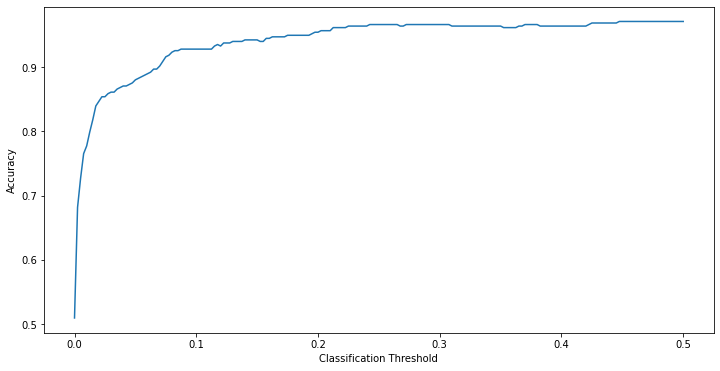

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(thresholds, val_accuracies)
ax.set_xlabel("Classification Threshold")
ax.set_ylabel("Accuracy")
plt.show()

We can see that when the threshod becomes less than 0.25, the validation accuracy starts dropping consistently. For this threshold, the validation accuracy drops only about 0.5% as shown below:

In [16]:
val_pred = ml.classifier_threshold(stacking, X_val, threshold=0.25)
print("Validation Accuracy:", accuracy_score(y_val, val_pred))

Validation Accuracy: 0.9665071770334929


So, we can now see the results on both the edge cases and the original test set.

In [17]:
inc_pred = ml.classifier_threshold(stacking, X_test_inc, threshold=0.25)
print("Mask Incorrect Use Accuracy:", accuracy_score(y_test_inc, inc_pred))

Mask Incorrect Use Accuracy: 0.375


In [18]:
test_pred = ml.classifier_threshold(stacking, X_test, threshold=0.25)
print("Test Accuracy:", accuracy_score(y_test, test_pred))

Test Accuracy: 0.9497607655502392


By changing the classification threshold, we almost doubled the accuracy on the edge cases, with only a 0.7% drop in overall test accuracy.<br>
In any practical application, we would need to judge how important are the edge cases in order to justify more false negatives (samples that do not wear a mask and yet were classified as if they were wearing one).